In [20]:
import ephem as eph
import numpy as np
import desimodel.io

_observer = None

def init_observer(long=-111.5967, lat=31.9583, date_time='2018/1/2 2:00'):
    """
    Initializes the observer position and date. Returns an
    ephen.Observer() object.  
    
    Args:
        long (float), longitude in degrees.
        lat (float), latitude in degrees.        
        date_time (string), date and time. default value is '2018/1/2 2:00'
        Default values for long and lat correspond to Kitt Peak.
    Returns:
        ephem.Observer() object.
        
    """
    global _observer
    _observer = eph.Observer()
    _observer.long = str(long)
    _observer.lat = str(lat)
    _observer.date = date_time
    return _observer

def radec_zenith():
    """
    Return RA,Dec at zenith.    
    Returns:
        RA (ephem.Angle) 
        Dec (ephem.Angle): 
    """
    altitude = 90.0
    azimuth = 0.0
    ra_zenith , dec_zenith = _observer.radec_of(str(azimuth), str(altitude))
    return ra_zenith, dec_zenith

def days_to_next_full_moon():
    """
    Compute the number of days to the next full moon
    Returns:
        n_days (float): number of days.
    """
    d1 = eph.next_new_moon(_observer.date)
    n_days = d1 - _observer.date 
    return n_days

def separation_azimuth_moon():
    """
    Compute the angle between azimuth and the Moon.
    Returns:
        a (ephem.Angle): angle between Moon and Azimuth.
    """
    up_ra, up_dec = radec_zenith()
    moon = eph.Moon()
    moon.compute(_observer.date)
    a = eph.separation([up_ra,up_dec], [moon.ra, moon.dec])
    return a

def points_inside_azimuth_cone(ra_list, dec_list, id_list, angle_to_zenith):
    """
    Selects a subset of points close to the zenith
    
    Args:
        ra_list (float): np.array with RA angles in degrees.
        dec_list (float): np.array with Dec angles in degrees.
        id_list (int): np.array with integers indexing the RA, DEC values
        angle_to_zenith (float): angle in degrees to zenith below which the list points are selected.
    Returns:
        The subset of points is represented by three arrays.
        ra_sublist (float): np.array with RA angles in degrees.
        dec_sublist (float): np.array with Dec angles in degrees.
        id_sublist (int): np.array with integers indexing the RA, DEC values.
    """
    assert angle_to_zenith >= 0.0, "Angle to zenith must be positive"
    assert angle_to_zenith <= 360.0, "Angle to zenith must be less than 360 degrees"
    
    ra_sublist = np.empty((0))
    dec_sublist = np.empty((0))
    id_sublist = np.empty((0), dtype='int')
    n_tiles = np.size(id_list)

    ra_list_radians = ra_list * np.pi/180.0
    dec_list_radians = dec_list * np.pi/180.0
    
    ra_up, dec_up = radec_zenith()
    for i_tile in np.arange(n_tiles):
        a = eph.separation([ra_up,dec_up], [ra_list_radians[i_tile], dec_list_radians[i_tile]])
        if(float(a) < (angle_to_zenith*np.pi/180.0)):
            id_sublist = np.append(id_sublist, id_list[i_tile])
            ra_sublist = np.append(ra_sublist, ra_list[i_tile])
            dec_sublist = np.append(dec_sublist, dec_list[i_tile])
    return ra_sublist, dec_sublist, id_sublist

In [21]:
_observer = init_observer()
ra_up, dec_up = radec_zenith()
print "angles", ra_up, type(dec_up), ra_up.real
print "days", days_to_next_full_moon()
print "sep", separation_azimuth_moon()

angles 1:19:15.92 <type 'ephem.Angle'> 0.34586061108
days 15.0119731233
sep 73:15:21.9


In [22]:
_tiles = desimodel.io.load_tiles()
id_tiles = _tiles['TILEID']
ra_tiles = _tiles['RA']
dec_tiles = _tiles['DEC']
n_pass = _tiles['PASS']
n_tiles = np.size(ra_tiles)

In [32]:
start_date = ' 2018/1/4 '
start_time = '3:00' 
end_time = '11:00'

_observer = init_observer(date_time=start_date+start_time)
initial_date = _observer.date

total_survey_days = 1
hours_per_day = 6
bright_time = True

hours = np.arange(hours_per_day)
days = np.arange(total_survey_days)

ra_todo = np.empty((0))
dec_todo = np.empty((0))

for day in days:
    for hour in hours:
        new_date = initial_date + day + hour*(1.0/24.0)
        _observer.date = new_date
        ra_up, dec_up = radec_zenith()
        n_to_full_moon = days_to_next_full_moon()
        
        if((n_to_full_moon>7) & (n_to_full_moon<21)):
            bright_time = True
        else:
            bright_time = False
        print ra_up, dec_up, n_to_full_moon, bright_time
        
        ra_in, dec_in, id_in = points_inside_azimuth_cone(ra_tiles, dec_tiles, id_tiles, 20.0)
        ra_todo = np.append(ra_todo, ra_in)
        dec_todo = np.append(dec_todo, dec_in)
        print np.size(ra_in)
        
    print

2:27:14.66 31:52:41.1 12.9703064566 True
189
3:27:21.45 31:53:49.3 12.9286397902 True
34
4:27:29.11 31:55:12.7 12.8869731233 True
0
5:27:37.81 31:56:45.6 12.8453064568 True
38
6:27:47.61 31:58:21.7 12.8036397902 True
284
7:27:58.53 31:59:54.4 12.7619731232 True
607



751
188


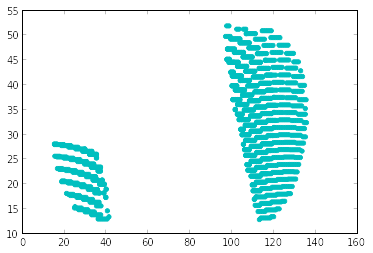

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(ra_todo, dec_todo, color='c')

In [11]:
start_date = ' 2018/1/2 '
start_time = '4:00' 
end_time = '11:00'

_observer = init_observer(date_time=start_date+start_time)
_observer.date

43100.666666666664

In [55]:
print(20.0*np.pi/180.0)

0.349065850399
